In [65]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout, Activation
from keras.layers import LSTM, GRU
from sklearn.metrics import mean_squared_error
from keras.optimizers import Adam, SGD, RMSprop
from sklearn.metrics import mean_squared_error
from keras.optimizers import Adam, SGD, RMSprop
from sklearn.preprocessing import MinMaxScaler

from common.utils import load_data, mape

In [66]:
data_dir = '/Users/dmalea/Git-Project-V2/energy_client'
dataset = load_data(data_dir)[['load']]
dataset.head()

,load
2023-05-15 00:15:00,0.128
2023-05-15 00:30:00,0.128
2023-05-15 00:45:00,0.128
2023-05-15 01:00:00,0.112
2023-05-15 01:15:00,0.097


In [67]:
dataset = dataset.interpolate()

In [68]:
dataset.dtypes

load    float64
dtype: object

In [69]:
training_data_len = int(np.ceil(len(dataset) * 0.8))

In [70]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [71]:
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []

In [72]:
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []

In [73]:
for i in range(60, len(train_data)):
    x_train.append(train_data[i - 60:i, 0])
    y_train.append(train_data[i, 0])

In [74]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [75]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [76]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

/Users/dmalea/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [77]:
model.compile(optimizer='adam', loss='mean_squared_error')


In [78]:
model.fit(x_train, y_train, batch_size=1, epochs=5)


Epoch 1/5


478/478 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.0097
Epoch 2/5
478/478 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0069
Epoch 3/5
478/478 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0075
Epoch 4/5
478/478 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0050
Epoch 5/5
478/478 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0072


In [79]:
test_data = scaled_data[training_data_len - 60:, :]
x_test = []
y_test = dataset[training_data_len:]
for i in range(60, len(test_data)):
    x_test.append(test_data[i - 60:i, 0])

In [80]:
x_test = np.array(x_test)

In [81]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [82]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


In [83]:
rmse = np.sqrt(np.mean(predictions - y_test) ** 2)
print('Root Mean Squared Error:', rmse)

Root Mean Squared Error: 0.017158813532831062


/var/folders/8c/dd7m1wk90r31n3w57f2ckjm40000gp/T/ipykernel_26849/1465330308.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


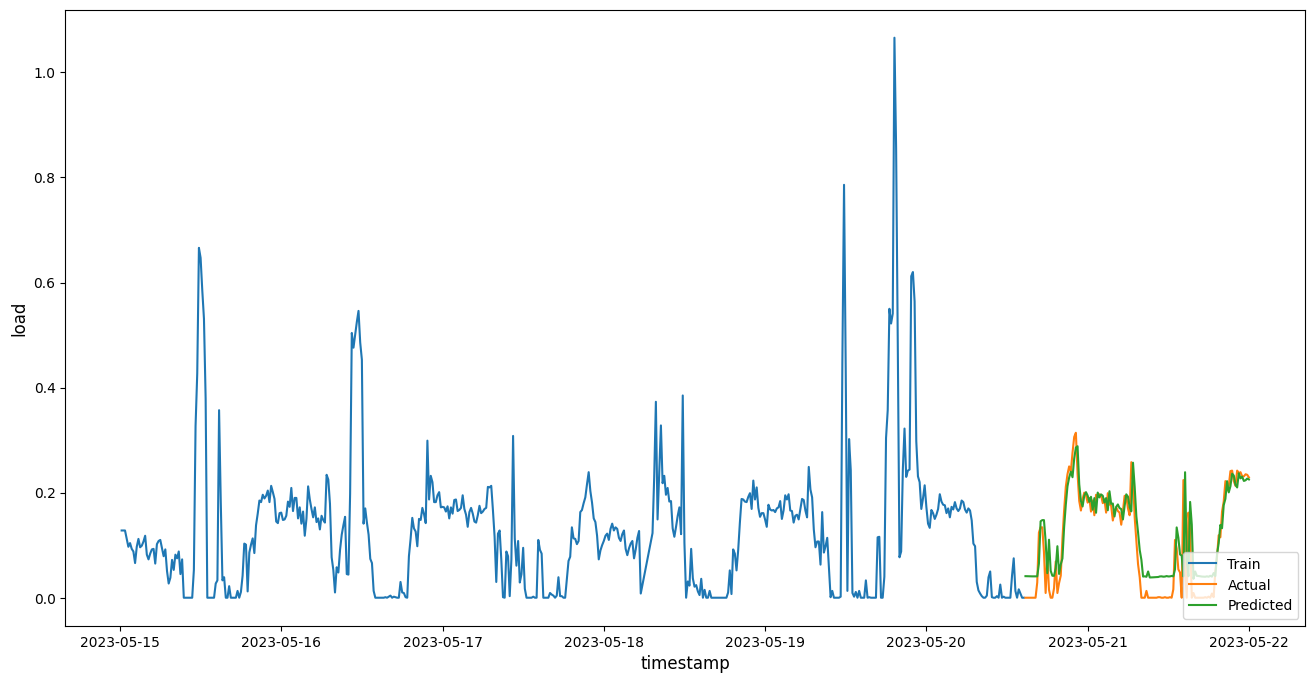

In [84]:
train = dataset[:training_data_len]
valid = dataset[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16, 8))
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.plot(train)
plt.plot(valid)
plt.legend(['Train', 'Actual', 'Predicted'], loc='lower right')
plt.show()